<a href="https://colab.research.google.com/github/anishjohnson/Face-Emotion-Recognition/blob/main/FER/Colab%20Notebook/Face_Emotion_Recognition_Anish_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Emotion Recognition**










# **Objective**
Our objective is to solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# **Dataset used**
We have utilized the [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset provided on Kaggle.<br>
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.<br>

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [1]:
!nvidia-smi
!nvcc -V

Wed Mar 15 17:01:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.33       Driver Version: 528.33       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8     9W /  80W |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Let's Begin:**

# **Data Exploration:**

**Lets start by importing the required libraries.**

In [2]:
# Basic python libraries.
import glob
import os.path as osp
import datetime
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import itertools
# Get rid of warnings!
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.utils.data as data
import shutil
import time
from tqdm import tqdm
print('Above libraries have been imported.')

Above libraries have been imported.


# **Data Preprocessing:**

In [3]:
def model_configuration():
  # Generic config
    width, height, channels = 48, 48, 3
    batch_size = 128
    num_classes = 7
  # validation_split = 0.1 # 45/5 per the He et al. paper
    verbose = 1
    n = 3
    init_fm_dim = 64
    shortcut_type = "identity" # or: projection

    # Create config dictionary
    config = {
        "width": width,
        "height": height,
        "dim": channels,
        "batch_size": batch_size,
        "num_classes": num_classes,
        "verbose": verbose,
        "stack_n": n,
        "initial_num_feature_maps": init_fm_dim,
        # "training_ds_size": train_size,
        # "steps_per_epoch": steps_per_epoch,
        # "val_steps_per_epoch": val_steps_per_epoch,
        "shortcut_type": shortcut_type
    }
    return config

# **Build Dataset:**

In [4]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))
            ]),
            
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [5]:
resize = 48
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)

In [6]:
def make_datapath_list(phase='train'):
    rootpath = './dataset/'
    target_path = osp.join(rootpath + phase + '/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

In [7]:
path_list = make_datapath_list('train')

./dataset/train/**/*.jpg


In [8]:
path_list[:10]

['./dataset/train\\angry\\Training_10118481.jpg',
 './dataset/train\\angry\\Training_10120469.jpg',
 './dataset/train\\angry\\Training_10131352.jpg',
 './dataset/train\\angry\\Training_10161559.jpg',
 './dataset/train\\angry\\Training_1021836.jpg',
 './dataset/train\\angry\\Training_10269675.jpg',
 './dataset/train\\angry\\Training_10278738.jpg',
 './dataset/train\\angry\\Training_10290703.jpg',
 './dataset/train\\angry\\Training_10295477.jpg',
 './dataset/train\\angry\\Training_10315441.jpg']

In [9]:
train_list = make_datapath_list('train')
val_list = make_datapath_list('val')

./dataset/train/**/*.jpg
./dataset/val/**/*.jpg


In [10]:
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('\\')[1]
        
        if label == "angry":
            label = 0
        elif label == "disgust":
            label = 1
        elif label == "fear":
            label = 2
        elif label == "happy":
            label = 3
        elif label == "neutral":
            label = 4
        elif label == "sad":
            label = 5
        elif label == "surprise":
            label = 6
        return img_transformed, label

In [11]:
train_set = MyDataset(train_list, transform = ImageTransform(resize, mean, std), phase = 'train')
val_set = MyDataset(val_list, transform = ImageTransform(resize, mean, std), phase = 'val')

In [12]:
index = 0
print(train_set.__len__())
print(train_set.__getitem__(index))

28709
(tensor([[[-0.6863, -0.7098, -0.6941,  ..., -0.5922, -0.5373, -0.4902],
         [-0.6392, -0.6784, -0.6784,  ..., -0.5765, -0.5216, -0.4667],
         [-0.6235, -0.6549, -0.6549,  ..., -0.5608, -0.5137, -0.4667],
         ...,
         [-0.3961, -0.3569, -0.2706,  ...,  0.2235,  0.2863,  0.3333],
         [-0.3333, -0.2863, -0.1922,  ...,  0.1922,  0.2392,  0.3020],
         [-0.2549, -0.2157, -0.1294,  ...,  0.2000,  0.2235,  0.2471]]]), 0)


In [13]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle = False)

dataloader_dict = {"train": train_loader, "val": val_loader}

In [14]:
batch_iterator = iter(dataloader_dict["train"])
inputs, labels =  next(batch_iterator)

In [15]:
print(inputs.size())

torch.Size([64, 1, 48, 48])


In [16]:
print(labels)

tensor([0, 3, 3, 4, 2, 2, 0, 6, 3, 5, 6, 0, 2, 2, 3, 3, 2, 6, 2, 6, 4, 3, 5, 4,
        6, 5, 3, 3, 2, 0, 4, 4, 5, 0, 5, 6, 0, 0, 0, 3, 5, 0, 5, 6, 3, 0, 4, 6,
        5, 3, 4, 4, 5, 4, 2, 6, 4, 2, 0, 1, 3, 2, 6, 4])


# **Build Model:**

In [17]:
class VGGNet(nn.Module):
    def __init__(self, num_classes=7, drop_rate=0.5):
        super(VGGNet, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),          
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),             
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
           
        )
        # self.flattened_tensor = nn.Flatten()
        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.fc_layers = nn.Sequential(
            nn.Linear(2304, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_rate),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGGNet().to(device)
print(model)

VGGNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [19]:
epochs = 2000
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
save_every = 50
# define your loss function
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, cooldown=0, min_lr=0.001, eps=1e-08)
# define your checkpoint callback function
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar', save_every=save_every):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'best_model.pth.tar')
    if state['epoch'] % save_every == 0:
        torch.save(state, f'checkpoint_epoch{state["epoch"]}.pth.tar')

# initialize variables for tracking training progress and best validation accuracy
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# train the model
for epoch in range(epochs):
    start=time.time()
    # train for one epoch
    model.to(device)
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # move inputs and labels to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()

    # calculate average training loss and accuracy for the epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # move inputs and labels to the same device as the model
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()

    # calculate average validation loss and accuracy for the epoch
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # update the learning rate scheduler based on validation loss
    scheduler.step(-val_loss)

    # save checkpoint and best model
    is_best = val_acc > best_val_acc
    best_val_acc = max(val_acc, best_val_acc)
    save_checkpoint({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }, is_best)

    # print training progress for the epoch
    stop=time.time()
    print(f'Time: {stop-start} Epoch {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f} Best Val Acc: {best_val_acc:.4f}')

print('Finished Training')

cuda
Time: 114.78372073173523 Epoch 1 Train Loss: 1.8236 Train Acc: 0.2508 Val Loss: 1.8150 Val Acc: 0.2471 Best Val Acc: 0.2471
Time: 37.26472020149231 Epoch 2 Train Loss: 1.8079 Train Acc: 0.2514 Val Loss: 1.7895 Val Acc: 0.2503 Best Val Acc: 0.2503
Time: 34.146591663360596 Epoch 3 Train Loss: 1.7861 Train Acc: 0.2523 Val Loss: 1.7818 Val Acc: 0.2627 Best Val Acc: 0.2627
Time: 34.63046669960022 Epoch 4 Train Loss: 1.7582 Train Acc: 0.2741 Val Loss: 1.7249 Val Acc: 0.3023 Best Val Acc: 0.3023
Time: 37.912769079208374 Epoch 5 Train Loss: 1.7141 Train Acc: 0.3009 Val Loss: 1.6828 Val Acc: 0.3307 Best Val Acc: 0.3307
Time: 34.60343909263611 Epoch 6 Train Loss: 1.6486 Train Acc: 0.3414 Val Loss: 1.5646 Val Acc: 0.3867 Best Val Acc: 0.3867
Time: 34.133410692214966 Epoch 7 Train Loss: 1.5841 Train Acc: 0.3761 Val Loss: 1.5045 Val Acc: 0.4075 Best Val Acc: 0.4075
Time: 34.00003957748413 Epoch 8 Train Loss: 1.5336 Train Acc: 0.4009 Val Loss: 1.4604 Val Acc: 0.4246 Best Val Acc: 0.4246
Time: 3

Time: 37.24990391731262 Epoch 67 Train Loss: 0.9075 Train Acc: 0.6598 Val Loss: 1.0131 Val Acc: 0.6220 Best Val Acc: 0.6220
Time: 41.37445092201233 Epoch 68 Train Loss: 0.9001 Train Acc: 0.6640 Val Loss: 1.0410 Val Acc: 0.6152 Best Val Acc: 0.6220
Time: 40.31630349159241 Epoch 69 Train Loss: 0.8985 Train Acc: 0.6668 Val Loss: 1.0413 Val Acc: 0.6205 Best Val Acc: 0.6220
Time: 36.94872283935547 Epoch 70 Train Loss: 0.8990 Train Acc: 0.6663 Val Loss: 1.0426 Val Acc: 0.6220 Best Val Acc: 0.6220
Time: 42.30509090423584 Epoch 71 Train Loss: 0.8863 Train Acc: 0.6700 Val Loss: 1.0402 Val Acc: 0.6141 Best Val Acc: 0.6220
Time: 41.21978235244751 Epoch 72 Train Loss: 0.8858 Train Acc: 0.6709 Val Loss: 1.0174 Val Acc: 0.6241 Best Val Acc: 0.6241
Time: 44.45250964164734 Epoch 73 Train Loss: 0.8827 Train Acc: 0.6717 Val Loss: 1.0425 Val Acc: 0.6202 Best Val Acc: 0.6241
Time: 43.72832417488098 Epoch 74 Train Loss: 0.8774 Train Acc: 0.6708 Val Loss: 1.0247 Val Acc: 0.6257 Best Val Acc: 0.6257
Time: 44

Time: 53.551310777664185 Epoch 133 Train Loss: 0.6149 Train Acc: 0.7757 Val Loss: 1.1584 Val Acc: 0.6392 Best Val Acc: 0.6404
Time: 52.74505591392517 Epoch 134 Train Loss: 0.6131 Train Acc: 0.7773 Val Loss: 1.2006 Val Acc: 0.6195 Best Val Acc: 0.6404
Time: 53.23426151275635 Epoch 135 Train Loss: 0.5949 Train Acc: 0.7851 Val Loss: 1.2029 Val Acc: 0.6379 Best Val Acc: 0.6404
Time: 53.27601766586304 Epoch 136 Train Loss: 0.5982 Train Acc: 0.7832 Val Loss: 1.2286 Val Acc: 0.6375 Best Val Acc: 0.6404
Time: 53.27270460128784 Epoch 137 Train Loss: 0.5889 Train Acc: 0.7856 Val Loss: 1.2300 Val Acc: 0.6390 Best Val Acc: 0.6404
Time: 53.40174841880798 Epoch 138 Train Loss: 0.5875 Train Acc: 0.7857 Val Loss: 1.2199 Val Acc: 0.6332 Best Val Acc: 0.6404
Time: 52.998213052749634 Epoch 139 Train Loss: 0.5792 Train Acc: 0.7890 Val Loss: 1.2224 Val Acc: 0.6332 Best Val Acc: 0.6404
Time: 52.50036287307739 Epoch 140 Train Loss: 0.5834 Train Acc: 0.7877 Val Loss: 1.2627 Val Acc: 0.6308 Best Val Acc: 0.640

Time: 35.17073917388916 Epoch 199 Train Loss: 0.3900 Train Acc: 0.8586 Val Loss: 1.5712 Val Acc: 0.6424 Best Val Acc: 0.6463
Time: 35.10202217102051 Epoch 200 Train Loss: 0.3833 Train Acc: 0.8648 Val Loss: 1.6168 Val Acc: 0.6337 Best Val Acc: 0.6463
Time: 35.320003032684326 Epoch 201 Train Loss: 0.3791 Train Acc: 0.8642 Val Loss: 1.5578 Val Acc: 0.6413 Best Val Acc: 0.6463
Time: 35.07599687576294 Epoch 202 Train Loss: 0.3779 Train Acc: 0.8658 Val Loss: 1.5128 Val Acc: 0.6453 Best Val Acc: 0.6463
Time: 35.12102746963501 Epoch 203 Train Loss: 0.3702 Train Acc: 0.8673 Val Loss: 1.5203 Val Acc: 0.6491 Best Val Acc: 0.6491
Time: 35.10779881477356 Epoch 204 Train Loss: 0.3825 Train Acc: 0.8627 Val Loss: 1.5364 Val Acc: 0.6443 Best Val Acc: 0.6491
Time: 34.8219473361969 Epoch 205 Train Loss: 0.3675 Train Acc: 0.8692 Val Loss: 1.5552 Val Acc: 0.6535 Best Val Acc: 0.6535
Time: 35.374147176742554 Epoch 206 Train Loss: 0.3628 Train Acc: 0.8716 Val Loss: 1.5525 Val Acc: 0.6424 Best Val Acc: 0.6535

Time: 42.385011196136475 Epoch 265 Train Loss: 0.2608 Train Acc: 0.9089 Val Loss: 1.7779 Val Acc: 0.6365 Best Val Acc: 0.6535
Time: 42.888988971710205 Epoch 266 Train Loss: 0.2570 Train Acc: 0.9101 Val Loss: 1.7569 Val Acc: 0.6454 Best Val Acc: 0.6535
Time: 42.03699851036072 Epoch 267 Train Loss: 0.2620 Train Acc: 0.9091 Val Loss: 1.6686 Val Acc: 0.6553 Best Val Acc: 0.6553
Time: 41.28775334358215 Epoch 268 Train Loss: 0.2573 Train Acc: 0.9094 Val Loss: 1.8102 Val Acc: 0.6431 Best Val Acc: 0.6553
Time: 41.44817137718201 Epoch 269 Train Loss: 0.2595 Train Acc: 0.9073 Val Loss: 1.8585 Val Acc: 0.6378 Best Val Acc: 0.6553
Time: 41.57503294944763 Epoch 270 Train Loss: 0.2570 Train Acc: 0.9087 Val Loss: 1.8342 Val Acc: 0.6395 Best Val Acc: 0.6553
Time: 41.28700804710388 Epoch 271 Train Loss: 0.2624 Train Acc: 0.9079 Val Loss: 1.7748 Val Acc: 0.6429 Best Val Acc: 0.6553
Time: 41.525882720947266 Epoch 272 Train Loss: 0.2587 Train Acc: 0.9087 Val Loss: 1.7600 Val Acc: 0.6456 Best Val Acc: 0.65

Time: 36.45367193222046 Epoch 331 Train Loss: 0.1958 Train Acc: 0.9321 Val Loss: 1.9211 Val Acc: 0.6524 Best Val Acc: 0.6577
Time: 41.3013219833374 Epoch 332 Train Loss: 0.1916 Train Acc: 0.9310 Val Loss: 2.0038 Val Acc: 0.6470 Best Val Acc: 0.6577
Time: 51.040428161621094 Epoch 333 Train Loss: 0.1877 Train Acc: 0.9328 Val Loss: 2.0672 Val Acc: 0.6446 Best Val Acc: 0.6577
Time: 49.191078186035156 Epoch 334 Train Loss: 0.1986 Train Acc: 0.9308 Val Loss: 1.9440 Val Acc: 0.6512 Best Val Acc: 0.6577
Time: 43.94518995285034 Epoch 335 Train Loss: 0.1937 Train Acc: 0.9330 Val Loss: 1.9995 Val Acc: 0.6450 Best Val Acc: 0.6577
Time: 52.80821943283081 Epoch 336 Train Loss: 0.1861 Train Acc: 0.9343 Val Loss: 2.0701 Val Acc: 0.6523 Best Val Acc: 0.6577
Time: 57.82306742668152 Epoch 337 Train Loss: 0.1874 Train Acc: 0.9337 Val Loss: 2.0275 Val Acc: 0.6486 Best Val Acc: 0.6577
Time: 51.14099431037903 Epoch 338 Train Loss: 0.1900 Train Acc: 0.9327 Val Loss: 2.0110 Val Acc: 0.6449 Best Val Acc: 0.6577

Time: 38.7083694934845 Epoch 397 Train Loss: 0.1568 Train Acc: 0.9447 Val Loss: 2.2573 Val Acc: 0.6527 Best Val Acc: 0.6590
Time: 37.06954574584961 Epoch 398 Train Loss: 0.1581 Train Acc: 0.9448 Val Loss: 2.1141 Val Acc: 0.6531 Best Val Acc: 0.6590
Time: 38.48404097557068 Epoch 399 Train Loss: 0.1538 Train Acc: 0.9463 Val Loss: 2.1856 Val Acc: 0.6453 Best Val Acc: 0.6590
Time: 40.208556175231934 Epoch 400 Train Loss: 0.1508 Train Acc: 0.9459 Val Loss: 2.2017 Val Acc: 0.6513 Best Val Acc: 0.6590
Time: 39.20055818557739 Epoch 401 Train Loss: 0.1593 Train Acc: 0.9436 Val Loss: 2.1535 Val Acc: 0.6482 Best Val Acc: 0.6590
Time: 39.54980158805847 Epoch 402 Train Loss: 0.1639 Train Acc: 0.9424 Val Loss: 2.1592 Val Acc: 0.6528 Best Val Acc: 0.6590
Time: 38.43165397644043 Epoch 403 Train Loss: 0.1547 Train Acc: 0.9468 Val Loss: 2.2095 Val Acc: 0.6521 Best Val Acc: 0.6590
Time: 39.17016386985779 Epoch 404 Train Loss: 0.1521 Train Acc: 0.9474 Val Loss: 2.2271 Val Acc: 0.6505 Best Val Acc: 0.6590


Time: 34.52675533294678 Epoch 463 Train Loss: 0.1309 Train Acc: 0.9532 Val Loss: 2.3836 Val Acc: 0.6549 Best Val Acc: 0.6604
Time: 34.818000078201294 Epoch 464 Train Loss: 0.1362 Train Acc: 0.9524 Val Loss: 2.1586 Val Acc: 0.6558 Best Val Acc: 0.6604
Time: 34.53931450843811 Epoch 465 Train Loss: 0.1289 Train Acc: 0.9549 Val Loss: 2.2062 Val Acc: 0.6527 Best Val Acc: 0.6604
Time: 34.10000228881836 Epoch 466 Train Loss: 0.1295 Train Acc: 0.9551 Val Loss: 2.3746 Val Acc: 0.6569 Best Val Acc: 0.6604
Time: 33.92499566078186 Epoch 467 Train Loss: 0.1323 Train Acc: 0.9516 Val Loss: 2.2825 Val Acc: 0.6560 Best Val Acc: 0.6604
Time: 33.900002241134644 Epoch 468 Train Loss: 0.1268 Train Acc: 0.9574 Val Loss: 2.2534 Val Acc: 0.6560 Best Val Acc: 0.6604
Time: 34.31057167053223 Epoch 469 Train Loss: 0.1298 Train Acc: 0.9551 Val Loss: 2.2144 Val Acc: 0.6597 Best Val Acc: 0.6604
Time: 34.48099994659424 Epoch 470 Train Loss: 0.1296 Train Acc: 0.9544 Val Loss: 2.2730 Val Acc: 0.6513 Best Val Acc: 0.660

KeyboardInterrupt: 

#Save model

# **Model evaluation:**

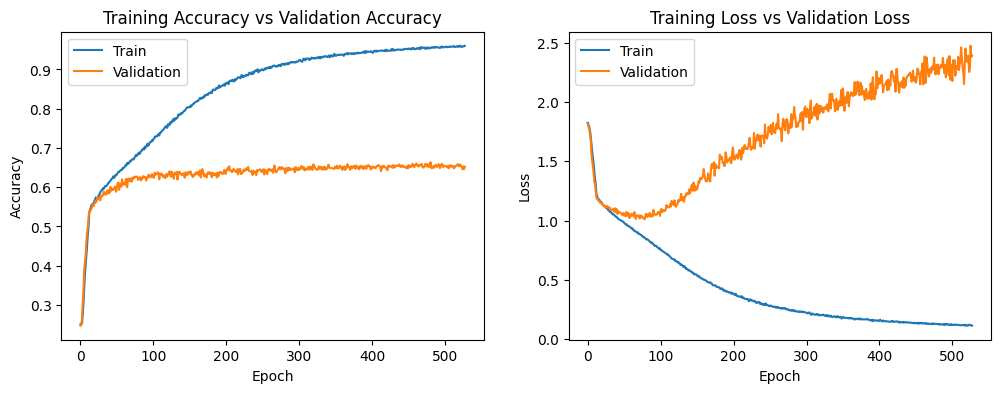

In [20]:
# Create plots for accuracy and loss.
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)

ax[0].plot(train_accs)
ax[0].plot(val_accs)
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Pretrain Model


epoch
model_state_dict
optimizer_state_dict
train_loss
train_acc
val_loss
val_acc


<Figure size 640x480 with 0 Axes>

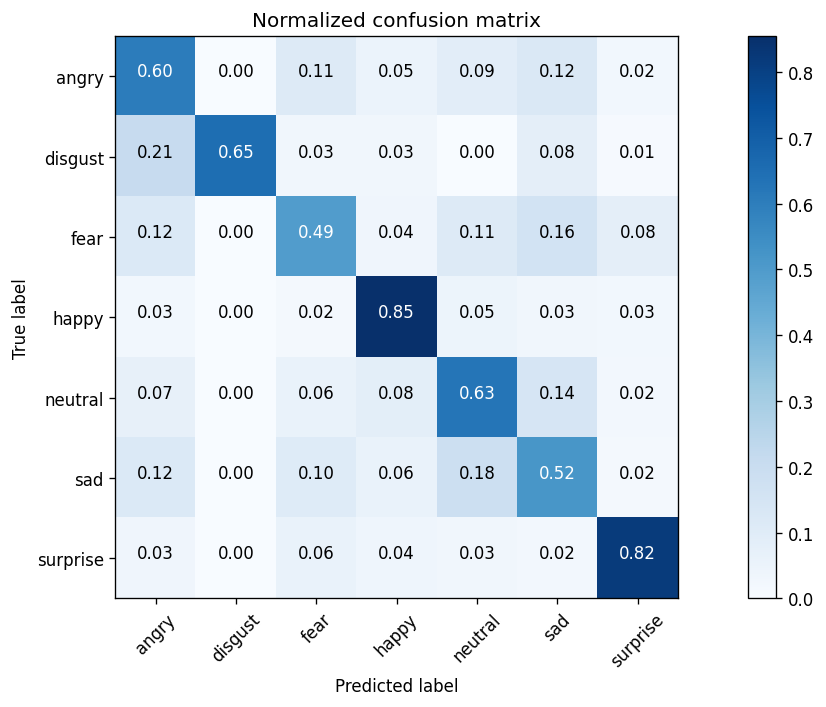

In [23]:
import numpy as np
import torch
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# load the checkpoint file
checkpoint = torch.load('best_model.pth.tar')
for key in checkpoint:
    print(key)
        

# retrieve the model state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# compute predictions
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in val_set:
        inputs = inputs.to(device)
        inputs = inputs.unsqueeze(0)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred += preds.tolist()
        y_true.append(labels)  # remove .tolist()

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Create function to plot confusion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

Load model:

loaded_model = load_model("AlexNet_model-100iters.h5")
loaded_model.load_weights("AlexNet_model_weights-100iters.h5")